In [7]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from time import time

In [8]:
df_ncc = pd.read_csv("./ncc.binetflow")
df_ncc=df_ncc[~df_ncc['Label'].str.contains("Background", case=False, na=False)]
df_ncc = df_ncc.sample(25000)
df_iot = pd.read_csv("./iot23.csv").sample(25000)
df_ctu = pd.read_csv("./ctu.csv").sample(25000)
df_ctu=df_ctu[~df_ctu['Label'].str.contains("Background", case=False, na=False)]
df_ctu = df_ctu.sample(25000)

C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\157375421.py:1: DtypeWarning: Columns (1,9,10,11,12,13,15,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ncc = pd.read_csv("./ncc.binetflow")
C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\157375421.py:4: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_iot = pd.read_csv("./iot23.csv").sample(25000)
C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\157375421.py:5: DtypeWarning: Columns (5,8,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ctu = pd.read_csv("./ctu.csv").sample(25000)


In [9]:
df_iot['ActivityLabel'] = df_iot['label'].apply(lambda x: 0 if x == 'Benign' else 1)
df_iot = df_iot.drop(columns=['label'])
df_ctu['ActivityLabel'] = df_ctu['BOTNET'].apply(lambda x: 0 if x == 0 else 1)
df_ctu = df_ctu.drop(columns=['BOTNET'])

In [10]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def plot_traffic_graph(df, src_col, dst_col, activity_col,dataset_name):
    df= df.head(5000)
    # Create the directed graph
    G = nx.Graph()
    # Add edges to the graph
    for _, row in df.iterrows():
        G.add_edge(row[src_col], row[dst_col], activity=row['ActivityLabel'])

    # Define node colors based on the ActivityLabel
    node_colors = []
    for node in G.nodes:
        if node in df[src_col].values:
            activity = df[df[src_col] == node]['ActivityLabel'].values[0]
        elif node in df[dst_col].values:
            activity = df[df[dst_col] == node]['ActivityLabel'].values[0]
        else:
            activity = 0  # Default to normal if no activity is found

        if activity == 1:
            node_colors.append('red')  # Botnet node
        else:
            node_colors.append('blue')  # Normal node

    # Draw the graph
    plt.figure(figsize=(12, 12))
    nx.draw_networkx(G, node_color=node_colors, with_labels=False, node_size=50)
    plt.title(f'Network Traffic with Botnet (Red) and Normal (Blue) Nodes for {dataset_name}')
    plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler

def calculate_additional_graph_metrics(G):
    # Calculate in-degree and out-degree
    in_degree = dict(G.in_degree())
    out_degree = dict(G.out_degree())

    # Calculate eigenvector centrality
    eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

    # Calculate betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G)

    return in_degree, out_degree, eigenvector_centrality, betweenness_centrality


def convert_categorical_to_numeric(df):
    le = LabelEncoder()
    for column in df.columns:
        if df[column].dtype == 'object' or df[column].dtype.name == 'category':
            df[column] = le.fit_transform(df[column])
    return df

def convert_categorical_to_numeric(df,src_col="SrcAddr",dst_col="DstAddr"):
    le = LabelEncoder()
    encoding_maps = {}
    for column in df.columns:
        if column == src_col or column == dst_col:
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = le.fit_transform(df[column])
                encoding_maps[column] = dict(zip(le.transform(le.classes_), le.classes_))
        else:
            if df[column].dtype == 'object' or df[column].dtype.name == 'category':
                df[column] = df[column].astype(str)
                df[column] = le.fit_transform(df[column])
    return df, encoding_maps

def feature_selection_vif(dataset, srcLabel, dstLabel, alpha=0.005, vif_threshold=20):
    # Load and clean the dataset
    df = dataset
    df = df.drop_duplicates()
    df = df.dropna()

    df['ActivityLabel'] = df['ActivityLabel'].apply(lambda x: 0 if x == 0 else 1)

    # Convert non-numeric features to numeric
    df, maps = convert_categorical_to_numeric(df,srcLabel,dstLabel)

    # Create the graph from IPs
    ips = df[[srcLabel, dstLabel]]
    G = nx.DiGraph()
    for _, row in ips.iterrows():
        G.add_edge(row[srcLabel], row[dstLabel])

    # Calculate centrality metrics
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    def refined_normalize(metric):
        values = np.array(list(metric.values()))
        if len(values) == 0 or values.max() == values.min():
            return dict(zip(metric.keys(), values))
        percentiles = np.percentile(values, np.linspace(0, 100, 101))
        normalized_values = np.interp(values, percentiles, np.linspace(0, 1, 101))
        return dict(zip(metric.keys(), normalized_values))

    degree_centrality_norm = refined_normalize(degree_centrality)
    closeness_centrality_norm = refined_normalize(closeness_centrality)
    betweenness_centrality_norm = refined_normalize(betweenness_centrality)

    # Compute Composite Node Importance (CNI)
    cni_scores = {}
    for node in G.nodes():
        cni_scores[node] = (degree_centrality_norm.get(node, 0) +
                            closeness_centrality_norm.get(node, 0) +
                            betweenness_centrality_norm.get(node, 0)) / 3

    # Calculate additional graph metrics
    in_degree, out_degree, eigenvector_centrality, betweenness_centrality = calculate_additional_graph_metrics(G)

    # Add CNI scores and other metrics to the dataset
    dataset_with_metrics = df.copy()
    dataset_with_metrics['orig_h_CNI'] = dataset_with_metrics[srcLabel].map(cni_scores)
    dataset_with_metrics['resp_h_CNI'] = dataset_with_metrics[dstLabel].map(cni_scores)
    dataset_with_metrics['average_CNI'] = dataset_with_metrics[['orig_h_CNI', 'resp_h_CNI']].mean(axis=1)

    ip_cni_map = {ip: cni_scores[ip] for ip in cni_scores if ip in dataset_with_metrics[srcLabel].unique() or ip in dataset_with_metrics[dstLabel].unique()}
    df_final = dataset_with_metrics

    # Normalize the features
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_final), columns=df_final.columns)

    # Calculate traditional VIF
    def calculate_vif(df):
        df = df.drop(["orig_h_CNI", "resp_h_CNI"], axis=1)
        X = df.values
        vif_scores = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
        vif_data = pd.DataFrame({'Feature': df.columns, 'Traditional_VIF': vif_scores})
        return vif_data

    
    start_time_1 = time()
    vif_results = calculate_vif(df_normalized)
    vif_time = time() - start_time_1
    vif_scores = vif_results

    # Iterative VIF-based feature selection
    features_to_remove = []
    high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()
    while high_vif_features:
        feature_to_remove = high_vif_features[0]
        features_to_remove.append(feature_to_remove)
        vif_results = vif_results[vif_results['Feature'] != feature_to_remove]
        remaining_features = vif_results['Feature'].tolist()
        X_subset = df_normalized[remaining_features]
        vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
        high_vif_features = vif_results[vif_results['Traditional_VIF'] > vif_threshold]['Feature'].tolist()

    # Calculate Modified VIF
    def calculate_modified_vif(X, alpha):
        X = X.drop(["orig_h_CNI", "resp_h_CNI"], axis=1)
        
        features = X.columns
        mvif_data = []
        for feature in features:
            predictors = [feat for feat in features if feat != feature]
            model = LinearRegression().fit(X[predictors], X[feature])
            r_squared = model.score(X[predictors], X[feature])
            average_cni_mean = dataset_with_metrics['average_CNI'].mean()
            # Normalizing the adjustment term
            normalized_adjustment = (r_squared + alpha * average_cni_mean) / (1 + alpha * average_cni_mean)
        
        # Ensure the value inside the division is positive
            if normalized_adjustment >= 1.0:
                normalized_adjustment = 1.0 - 1e-6  # Adjust to avoid negative or zero denominator

            modified_vif = 1 / (1 - normalized_adjustment)
            mvif_data.append({'Feature': feature, 'Modified_VIF': modified_vif})
        
        return pd.DataFrame(mvif_data)

    X = df_normalized
    start_time_1 = time()
    mvif_results = calculate_modified_vif(X, alpha)
    mvif_time = time() - start_time_1

    final_vif_results = pd.merge(vif_scores, mvif_results, on='Feature')
    selected_features = mvif_results[mvif_results['Modified_VIF'] < vif_threshold]['Feature'].tolist()
    selected_features_vif = vif_results[vif_results['Traditional_VIF'] < vif_threshold]['Feature'].tolist()

    return df_final, final_vif_results,mvif_time,vif_time,selected_features,selected_features_vif,maps,ip_cni_map


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from keras.utils import to_categorical

def create_ffnn(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_cnn(input_shape):
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', input_shape=input_shape))
    
    if input_shape[0] >= 4:
        model.add(MaxPooling1D(2))
        new_shape = input_shape[0] // 2
        if new_shape >= 5:
            model.add(Conv1D(64, 3, activation='relu'))
            if new_shape - 2 >= 2:
                model.add(MaxPooling1D(2))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def evaluate_models(features, df, label_col='ActivityLabel'):
    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear'),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True),
        'Ensemble (Voting)': VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(solver='liblinear')),
                ('rf', RandomForestClassifier()),
                ('svm', SVC(probability=True))
            ], voting='soft'
        )
    }
    
    results = {}
    
    X = df[features]
    y = df[label_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    for model_name, model in models.items():
        start_time = time()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        computation_time = time() - start_time
        
        results[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'Computation Time': computation_time,
            "Model":model
        }
    
    start_time = time()
    ffnn = create_ffnn(X_train.shape[1])
    ffnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred_ffnn = (ffnn.predict(X_test) > 0.5).astype(int).flatten()
    accuracy_ffnn = accuracy_score(y_test, y_pred_ffnn)
    precision_ffnn = precision_score(y_test, y_pred_ffnn)
    recall_ffnn = recall_score(y_test, y_pred_ffnn)
    f1_ffnn = f1_score(y_test, y_pred_ffnn)
    computation_time_ffnn = time() - start_time
    
    results['FFNN'] = {
        'Accuracy': accuracy_ffnn,
        'Precision': precision_ffnn,
        'Recall': recall_ffnn,
        'F1-Score': f1_ffnn,
        'Computation Time': computation_time_ffnn,
        "Model":ffnn
    }
    
    start_time = time()
    X_train_cnn = np.expand_dims(X_train, axis=2)
    X_test_cnn = np.expand_dims(X_test, axis=2)
    input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])
    cnn = create_cnn(input_shape)
    cnn.fit(X_train_cnn, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred_cnn = (cnn.predict(X_test_cnn) > 0.5).astype(int).flatten()
    accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
    precision_cnn = precision_score(y_test, y_pred_cnn)
    recall_cnn = recall_score(y_test, y_pred_cnn)
    f1_cnn = f1_score(y_test, y_pred_cnn)
    computation_time_cnn = time() - start_time
    
    results['CNN'] = {
        'Accuracy': accuracy_cnn,
        'Precision': precision_cnn,
        'Recall': recall_cnn,
        'F1-Score': f1_cnn,
        'Computation Time': computation_time_cnn,
        "Model":cnn
    }
    
    return results

In [32]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from time import time
from sklearn.model_selection import KFold
from scipy.stats import sem

def compute_confidence_interval(values):
    """
    Compute 95% confidence interval for a list of values.
    Returns a tuple of (lower_bound, upper_bound).
    """
    mean = np.mean(values)
    error = 1.96 * (np.std(values, ddof=1) / np.sqrt(len(values)))
    return (mean - error, mean + error), error

def kfold_validation(models, X, y, k=5):
    """
    Perform K-Fold Cross Validation on given models.
    Returns average metrics and confidence intervals across all folds.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = {}

    for model_name, model in models.items():
        accuracies, precisions, recalls, f1s, times = [], [], [], [], []

        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            start_time = time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            accuracies.append(accuracy_score(y_val, y_pred))
            precisions.append(precision_score(y_val, y_pred))
            recalls.append(recall_score(y_val, y_pred))
            f1s.append(f1_score(y_val, y_pred))
            times.append(time() - start_time)

        # Calculate confidence intervals and error
        accuracy_ci, accuracy_error = compute_confidence_interval(accuracies)
        precision_ci, precision_error = compute_confidence_interval(precisions)
        recall_ci, recall_error = compute_confidence_interval(recalls)
        f1_ci, f1_error = compute_confidence_interval(f1s)

        results[model_name] = {
            'Accuracy': np.mean(accuracies),
            'Accuracy Values': accuracies,
            'Accuracy CI': accuracy_ci,
            'Accuracy Error': accuracy_error,
            'Precision': np.mean(precisions),
            'Precision Values': precisions,
            'Precision CI': precision_ci,
            'Precision Error': precision_error,
            'Recall': np.mean(recalls),
            'Recall CI': recall_ci,
            'Precision Values': recalls,
            'Recall Error': recall_error,
            'F1-Score': np.mean(f1s),
            'F1-Score CI': f1_ci,
            'F1-Score Error': f1_error,
            'F1-Score Values': f1s,
            'Computation Time': np.mean(times),
            "Model": model
        }
    return results


def kfold_validation_neural_network(create_model, X, y, k=5, epochs=10, batch_size=32):
    """
    Perform K-Fold Cross Validation on neural networks (FFNN/CNN).
    Returns average metrics and confidence intervals across all folds.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies, precisions, recalls, f1s, times = [], [], [], [], []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        start_time = time()
        model = create_model(X_train.shape[1] if len(X_train.shape) == 2 else (X_train.shape[1], 1))
        
        # Expand dimensions for CNN
        if len(X_train.shape) == 2:
            X_train = np.expand_dims(X_train, axis=2)
            X_val = np.expand_dims(X_val, axis=2)

        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        y_pred = (model.predict(X_val) > 0.5).astype(int).flatten()
        
        accuracies.append(accuracy_score(y_val, y_pred))
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))
        f1s.append(f1_score(y_val, y_pred))
        times.append(time() - start_time)

    # Calculate confidence intervals and error
    accuracy_ci, accuracy_error = compute_confidence_interval(accuracies)
    precision_ci, precision_error = compute_confidence_interval(precisions)
    recall_ci, recall_error = compute_confidence_interval(recalls)
    f1_ci, f1_error = compute_confidence_interval(f1s)

    return {
        'Accuracy': np.mean(accuracies),
        'Accuracy Values': accuracies,
        'Accuracy CI': accuracy_ci,
        'Accuracy Error': accuracy_error,
        'Precision': np.mean(precisions),
        'Precision Values': precisions,
        'Precision CI': precision_ci,
        'Precision Error': precision_error,
        'Recall': np.mean(recalls),
        'Recall CI': recall_ci,
        'Precision Values': recalls,
        'Recall Error': recall_error,
        'F1-Score': np.mean(f1s),
        'F1-Score CI': f1_ci,
        'F1-Score Error': f1_error,
        'F1-Score Values': f1s,
        'Computation Time': np.mean(times),
        "Model": create_model
    }


# Main evaluation function
def evaluate_models_with_cross_validation(features, df, label_col='ActivityLabel', k=5):
    models = {
        'Logistic Regression': LogisticRegression(solver='liblinear'),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(probability=True),
        'Ensemble (Voting)': VotingClassifier(
            estimators=[
                ('lr', LogisticRegression(solver='liblinear')),
                ('rf', RandomForestClassifier()),
                ('svm', SVC(probability=True))
            ], voting='soft'
        )
    }

    # Prepare data
    X = df[features].values
    y = df[label_col].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # K-Fold Validation for traditional models
    results = kfold_validation(models, X, y, k=k)

    # K-Fold Validation for FFNN
    results['FFNN'] = kfold_validation_neural_network(create_ffnn, X, y, k=k, epochs=10, batch_size=32)

    # K-Fold Validation for CNN
    X_cnn = np.expand_dims(X, axis=2)
    results['CNN'] = kfold_validation_neural_network(create_cnn, X_cnn, y, k=k, epochs=10, batch_size=32)

    return results


In [33]:
def plot_results(results, title,dataset_name):
    plot_data = []
    for model_name, result in results.items():
        plot_data.append({
            'Model': model_name,
            'Accuracy': result['Accuracy'],
            'Precision': result['Precision'],
            'Recall': result['Recall'],
            'F1-Score': result['F1-Score'],
            'Computation Time': result['Computation Time']
        })
    plot_df = pd.DataFrame(plot_data)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Accuracy', data=plot_df, palette='viridis')
    plt.title(f'Model Accuracy for {title} ')
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Precision', data=plot_df, palette='viridis')
    plt.title(f'Model Precision for {title} on {dataset_name}')
    plt.ylabel('Precision')
    plt.xlabel('Model')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Recall', data=plot_df, palette='viridis')
    plt.title(f'Model Recall for {title} on {dataset_name}')
    plt.ylabel('Recall')
    plt.xlabel('Model')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='F1-Score', data=plot_df, palette='viridis')
    plt.title(f'Model F1-Score for {title} on {dataset_name}')
    plt.ylabel('F1-Score')
    plt.xlabel('Model')
    plt.legend(loc='best')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Computation Time', data=plot_df, palette='viridis')
    plt.title(f'Model Computation Time for {title} on {dataset_name}')
    plt.ylabel('Computation Time (seconds)')
    plt.xlabel('Model')
    plt.legend(loc='best')
    plt.show()


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import StandardScaler



def get_top_cni_tuples(df, cni_column='orig_h_CNI', src_col='SrcAddr', top_n=50):
    # Ensure the CNI column exists in the DataFrame
    if cni_column not in df.columns:
        raise KeyError(f"Column '{cni_column}' not found in DataFrame.")
    
    # Get the top N entries based on the CNI values
    top_cni_tuples = df.nlargest(top_n, cni_column)[[src_col, cni_column]].itertuples(index=False)

    # Convert to a list of tuples
    top_cni_tuples_list = list(top_cni_tuples)

    print(top_cni_tuples_list)

def plot_botnet_graph(df_final, selected_features_mvif, results, maps, cni_maps,dataset_name, model_name='Logistic Regression', src_col='SrcAddr', dst_col='DstAddr'):
    # Load the model
    best_model = results[model_name]["Model"]

    # Predict labels
    X = df_final[selected_features_mvif]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y_pred = best_model.predict(X)
    df_final['Predicted_Label'] = y_pred
  
    # Filter for botnet nodes
    botnet_df = df_final[df_final['Predicted_Label'] == 1]

    # Reverse mappings for source and destination IPs
    reverse_mapping = {k: v for k, v in maps[src_col].items()}
    reverse_mapping_dst = {k: v for k, v in maps[dst_col].items()}
    
    botnet_df["SrcCNI"] = botnet_df[src_col].map(cni_maps).fillna('Unknown')
    botnet_df["DstCNI"] = botnet_df[dst_col].map(cni_maps).fillna('Unknown')
    print(botnet_df)
    # Apply mappings and handle cases where mapping might not exist
    botnet_df[src_col] = botnet_df[src_col].map(reverse_mapping).fillna('Unknown')
    botnet_df[dst_col] = botnet_df[dst_col].map(reverse_mapping_dst).fillna('Unknown')

    # Create and plot the botnet graph
    G = nx.Graph()
    for index, row in botnet_df.iterrows():
        if row[src_col] != 'Unknown' and row[dst_col] != 'Unknown':
            G.add_edge(row[src_col], row[dst_col])

    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G, seed=42)  # Positioning of nodes
    nx.draw(G, pos, with_labels=True, node_size=50, node_color='r', alpha=0.5)
    plt.title(f'Botnet Nodes Graph for {dataset_name}')
    plt.show()
    
    nx.draw(G, pos, node_size=50, node_color='r',alpha=0.5)
    plt.title(f'Botnet Nodes Graph for {dataset_name}')
    plt.show()
    
    unique_src_addr_df = botnet_df[[src_col,'SrcCNI']].drop_duplicates().reset_index(drop=True)
    unique_dst_addr_df = botnet_df[[dst_col,'DstCNI']].drop_duplicates().reset_index(drop=True)

    get_top_cni_tuples(df_final, 'orig_h_CNI', src_col, 50)
    # Print the unique SrcAddr DataFrame
    print("\nDataFrame of unique SrcAddr values:")
    print(unique_src_addr_df)
    
    print("\nDataFrame of unique DstAddr values:")
    print(unique_dst_addr_df)




In [35]:
def plot_metrics(results,dataset_name, metrics=None):
    """
    Plots line charts for specified metrics across different models.

    Parameters:
    - results: Dictionary containing model names as keys and a sub-dictionary of metrics as values.
    - metrics: List of metrics to plot. If None, all available metrics in the first model's results are plotted.

    Example:
    plot_metrics(results, metrics=['Accuracy', 'Precision'])
    """
    # Extract model names
    models = list(results.keys())

    # Determine the metrics to plot
    if metrics is None:
        # Use the keys of the first model's sub-dictionary as metrics if not provided
        metrics = list(results[models[0]].keys())
        # Remove 'Model' key if it exists
        metrics = [metric for metric in metrics if metric != 'Model']

    # Plot each metric
    for metric in metrics:
        plt.figure(figsize=(10, 6))
        
        # Extract values for each model for the current metric
        metric_values = [results[model][metric] for model in models]
        
        # Plotting
        plt.plot(models, metric_values, marker='o', label=metric)
        plt.title(f'{metric} for Each Model for {dataset_name}')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [36]:
def process_and_plot(df, src_col, dst_col, activity_col,dataset_name, model_name='Logistic Regression'):
    # Plot traffic graph
    plot_traffic_graph(df, src_col, dst_col, activity_col,dataset_name)

    # Perform feature selection
    df_final, final_vif_results, mvif_time, vif_time, selected_features_mvif, selected_features_vif, maps,ip_cni_maps = feature_selection_vif(df, src_col, dst_col)

    # Evaluate models
    results = evaluate_models_with_cross_validation(selected_features_mvif, df_final)

    # Plot results
    plot_results(results, "CNI_VIF",dataset_name)
    plot_metrics(results,dataset_name)
    df = pd.DataFrame(results).T

    
    print(df)

#     # Plot botnet graph
    plot_botnet_graph(df_final, selected_features_mvif, results, maps,ip_cni_maps,dataset_name, model_name,src_col,dst_col,)


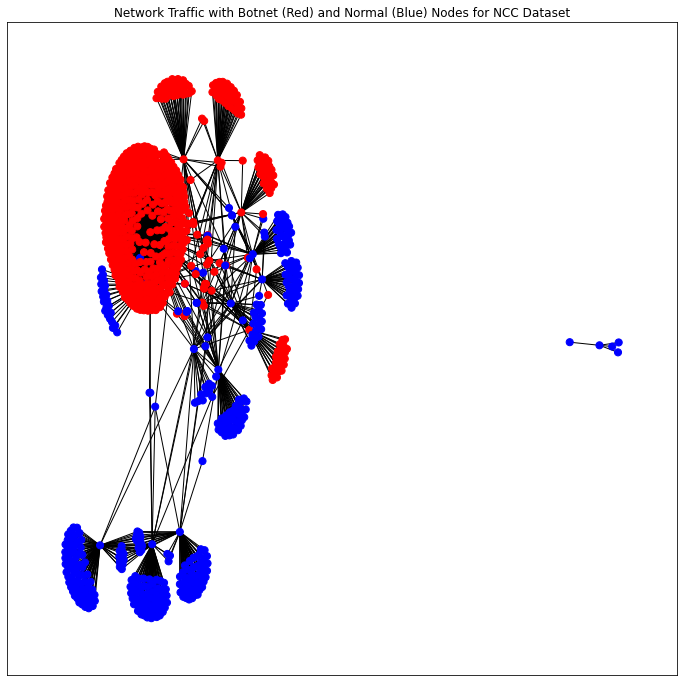

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1706602215.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

64/64 [==============================] - 0s 3ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


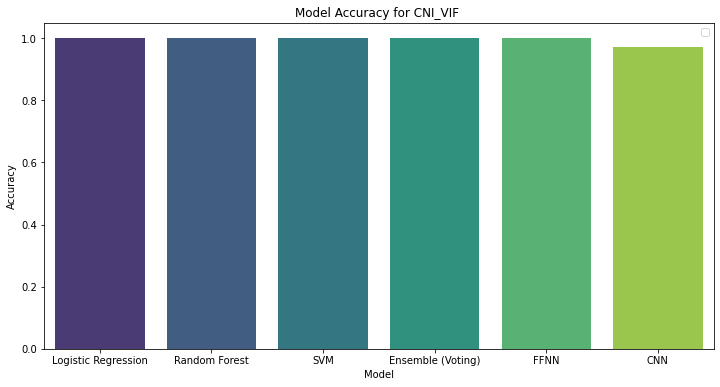

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


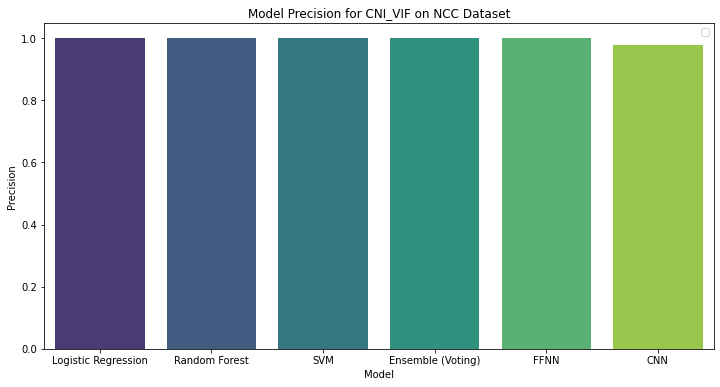

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


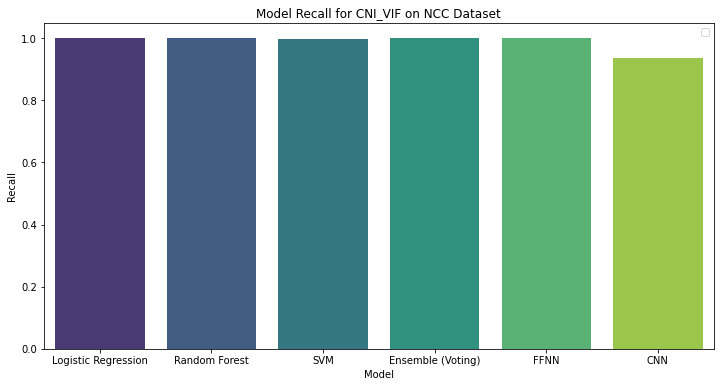

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


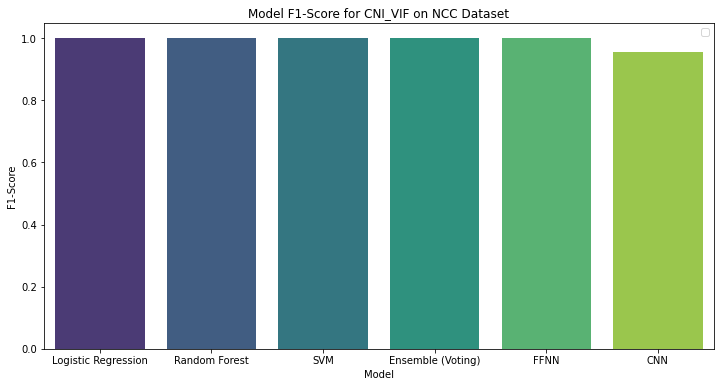

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


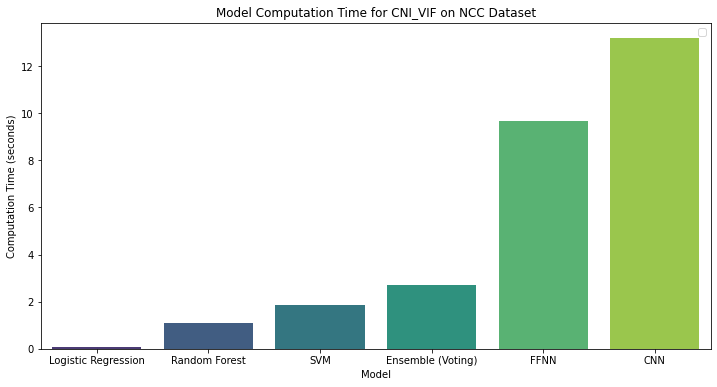

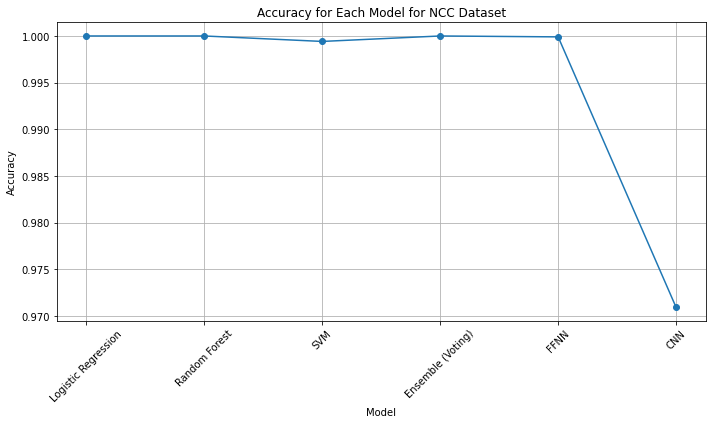

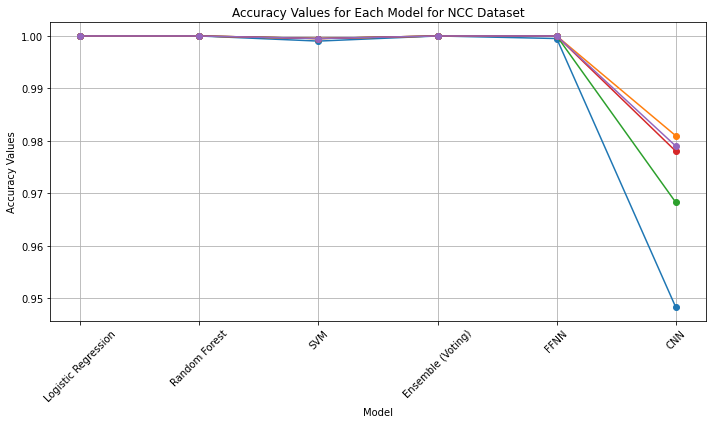

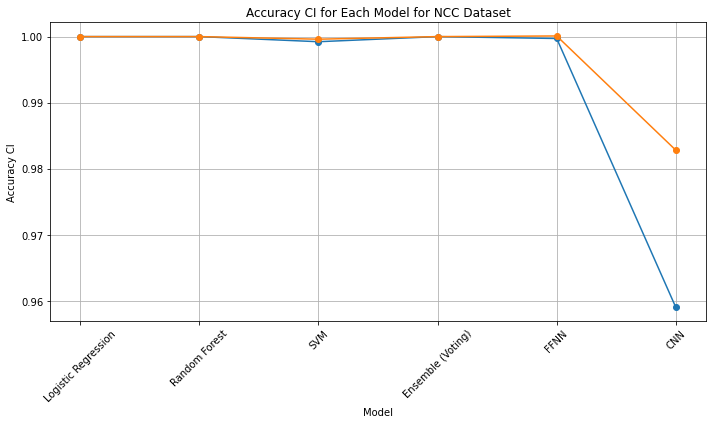

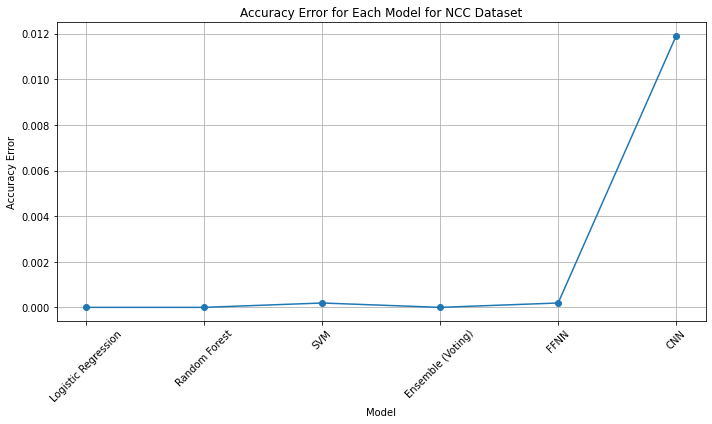

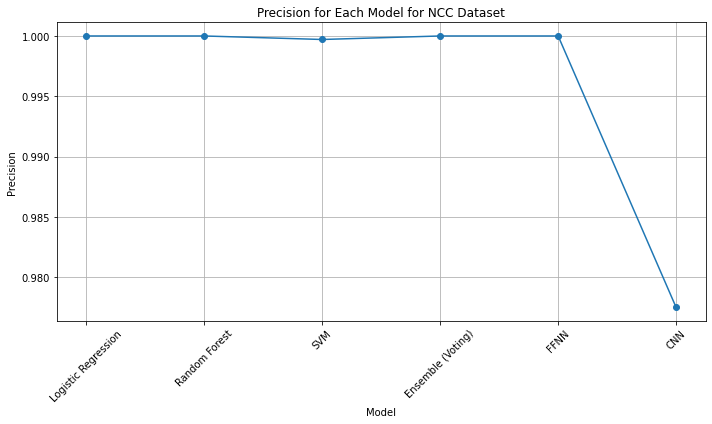

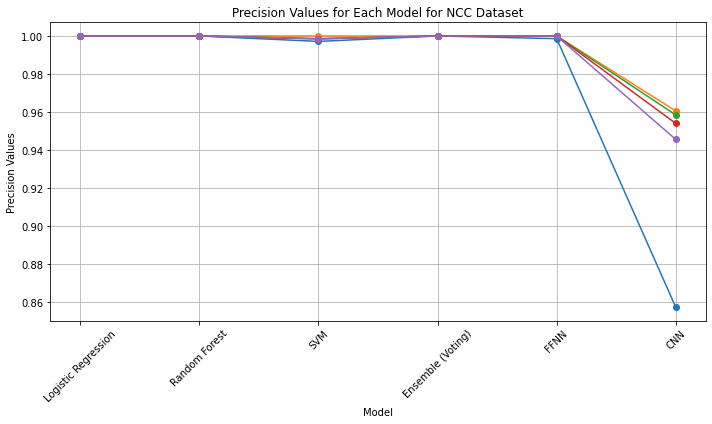

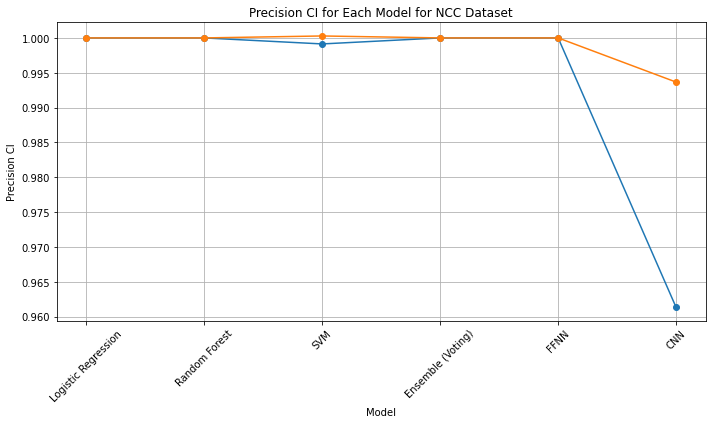

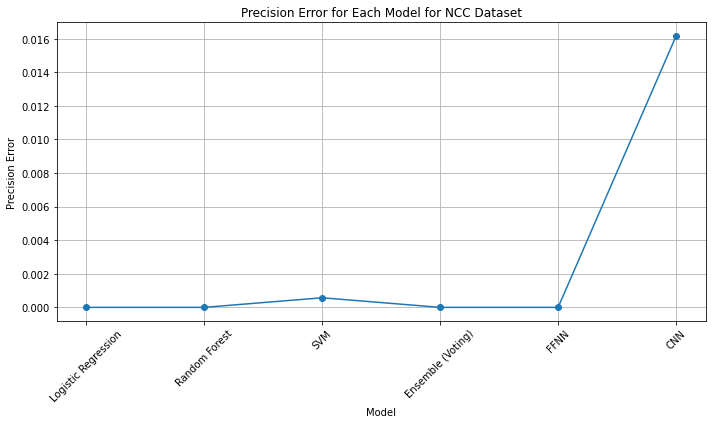

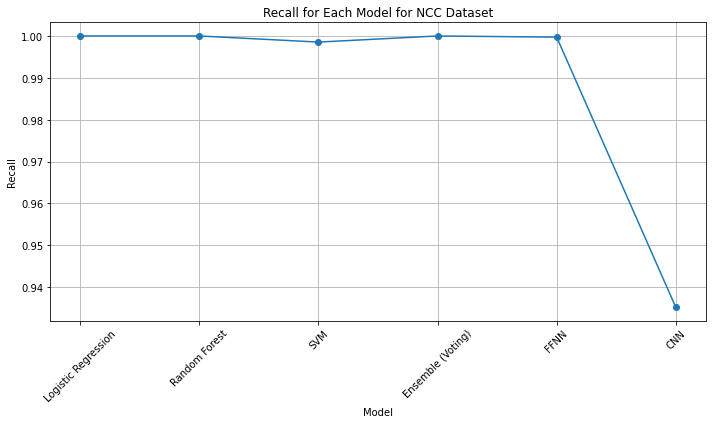

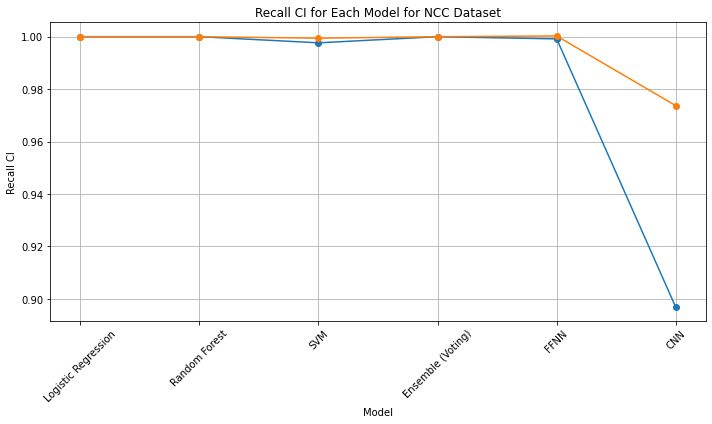

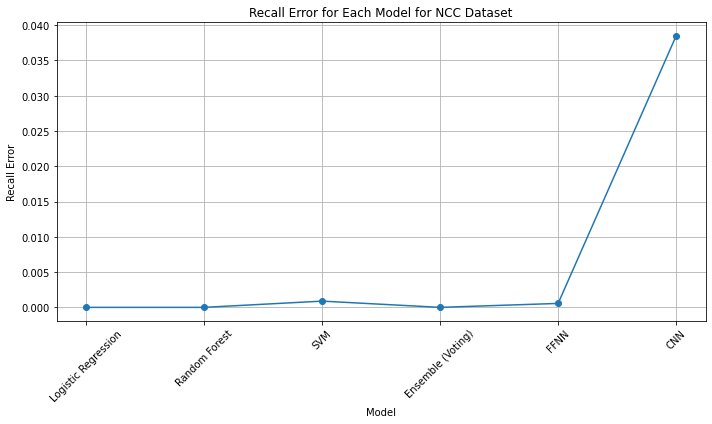

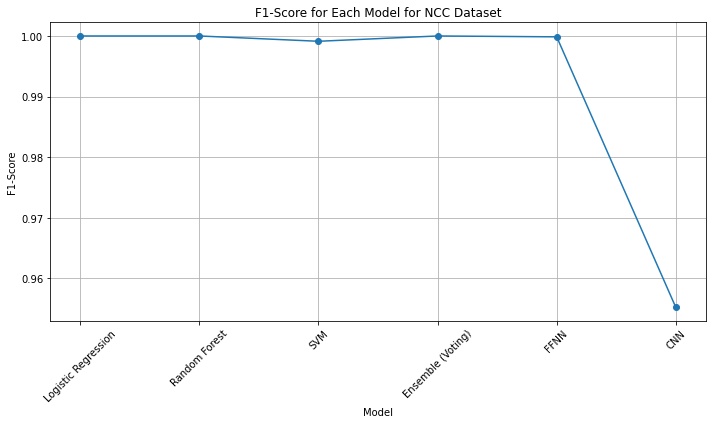

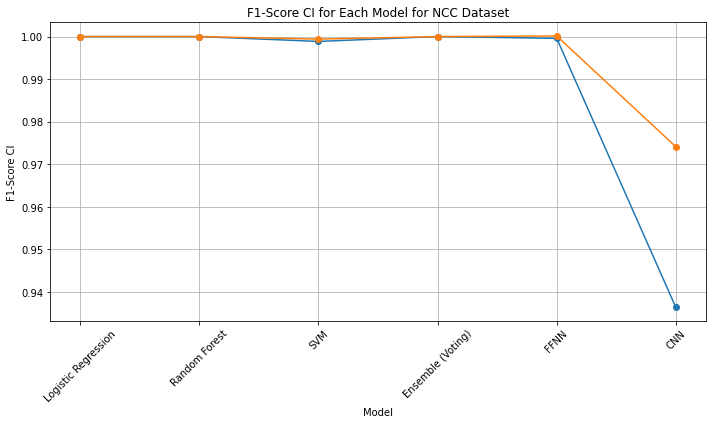

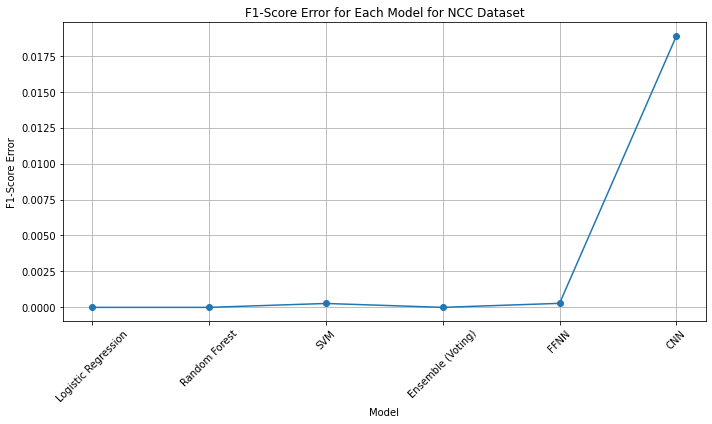

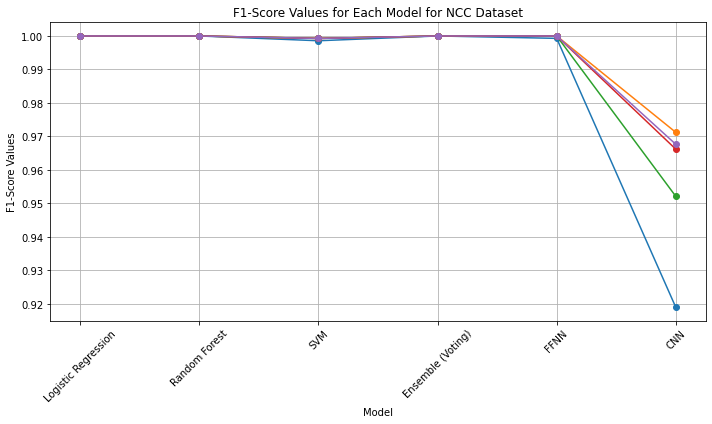

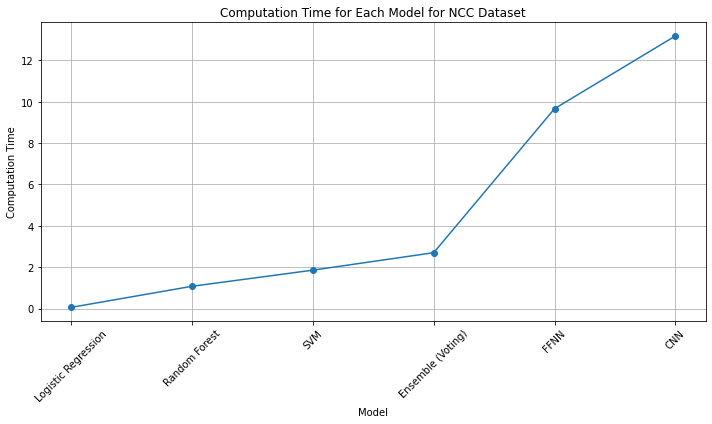

                     Accuracy  \
Logistic Regression       1.0   
Random Forest             1.0   
SVM                  0.999414   
Ensemble (Voting)         1.0   
FFNN                 0.999902   
CNN                  0.970905   

                                                       Accuracy Values  \
Logistic Regression                          [1.0, 1.0, 1.0, 1.0, 1.0]   
Random Forest                                [1.0, 1.0, 1.0, 1.0, 1.0]   
SVM                  [0.9990239141044412, 0.9995119570522206, 0.999...   
Ensemble (Voting)                            [1.0, 1.0, 1.0, 1.0, 1.0]   
FFNN                          [0.9995119570522206, 1.0, 1.0, 1.0, 1.0]   
CNN                  [0.9482674475353832, 0.9809663250366032, 0.968...   

                                                  Accuracy CI Accuracy Error  \
Logistic Regression                                (1.0, 1.0)            0.0   
Random Forest                                      (1.0, 1.0)            0.0   
SVM      

C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df["SrcCNI"] = botnet_df[src_col].map(cni_maps).fillna('Unknown')
C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df["DstCNI"] = botnet_df[dst_col].map(cni_maps).fillna('Unknown')


        Unnamed: 0.1  Unnamed: 0       Dur  Proto  SrcAddr  Sport  Dir  \
734438       1709594     1709594  0.685481      1        2    207    1   
677835       1418847     1418847  0.257905      1       12    212    1   
663081       1344158     1344158  0.225593      1        5     99    1   
722436       1647237     1647237  0.002371      1        9     96    1   
674063       1401163     1401163  0.190306      1        2    299    1   
...              ...         ...       ...    ...      ...    ...  ...   
451737       2616194     2616194  0.062646      1        2    441    1   
487367       1668753     1668753  0.340450      0        2    570    0   
429991       1750419     1750419  0.055975      1        2    441    1   
795945       2042253     2042253  0.000408      1       12    212    1   
781658       1953366     1953366  0.143408      1        2    204    1   

        DstAddr  Dport  State  ...  Label  Train  StartTime  ActivityLabel  \
734438       37     43      0  ..

C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[src_col] = botnet_df[src_col].map(reverse_mapping).fillna('Unknown')
C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[dst_col] = botnet_df[dst_col].map(reverse_mapping_dst).fillna('Unknown')


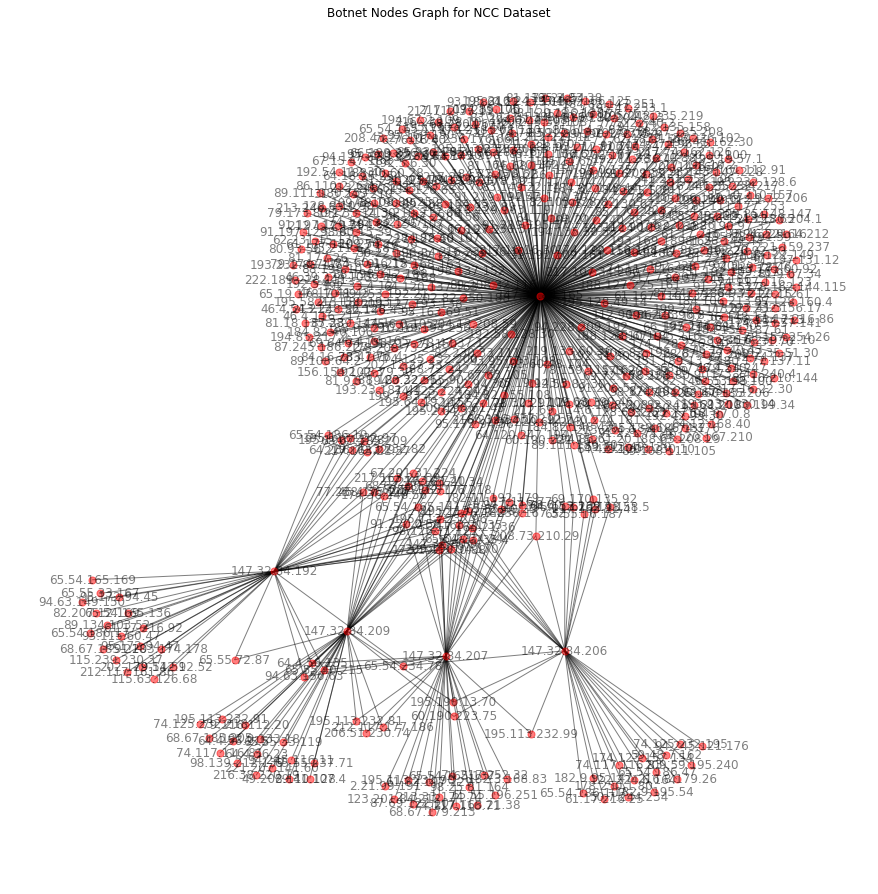

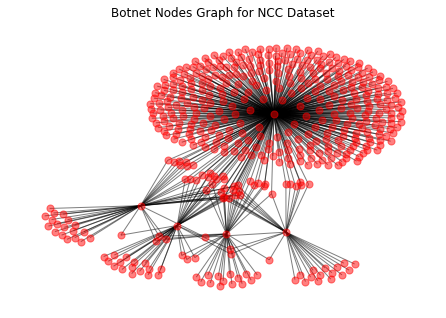

[Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=0.9469092984741225), Pandas(SrcAddr=10, orig_h_CNI=

In [37]:
process_and_plot(df_ctu,"SrcAddr","DstAddr","ActivityLabel","NCC Dataset")

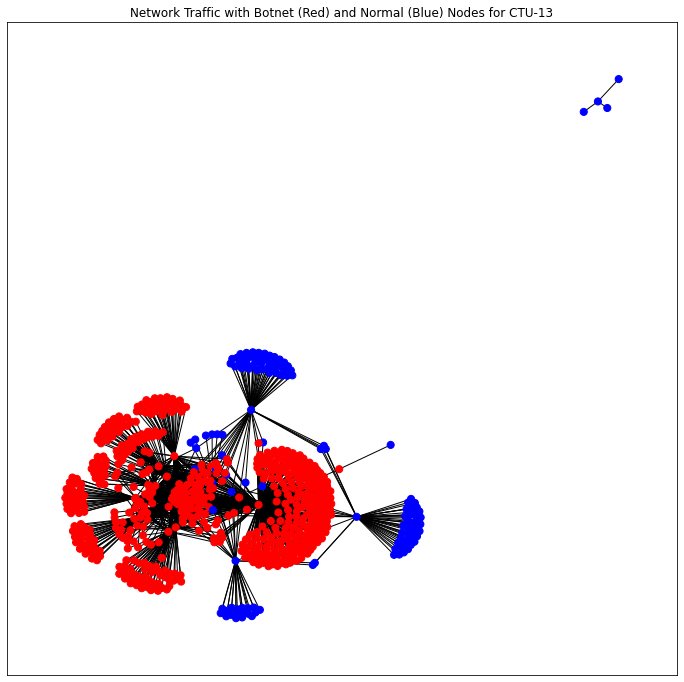

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1706602215.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\r

135/135 [==============================] - 1s 4ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


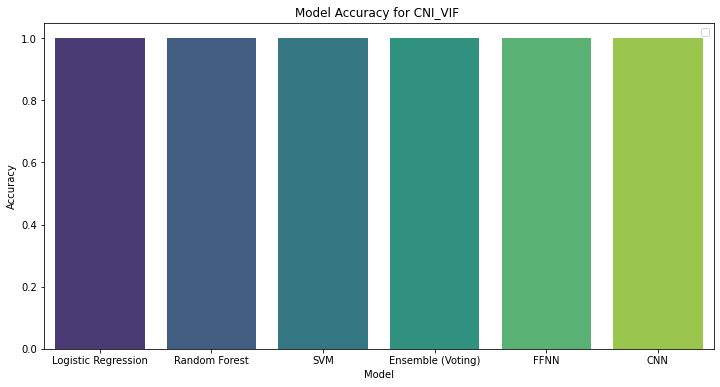

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


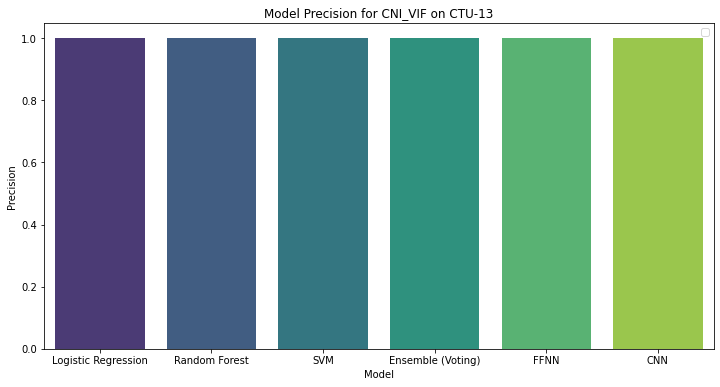

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


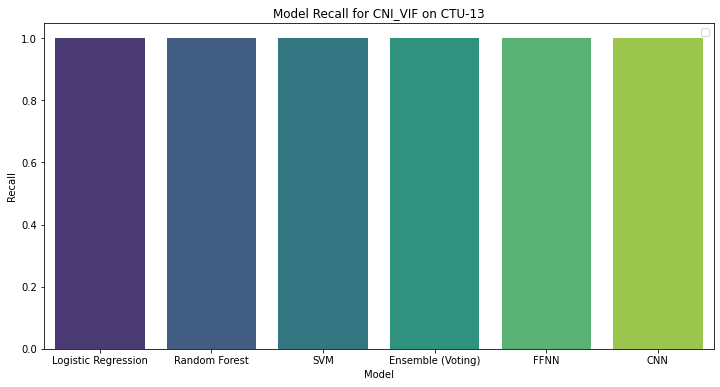

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


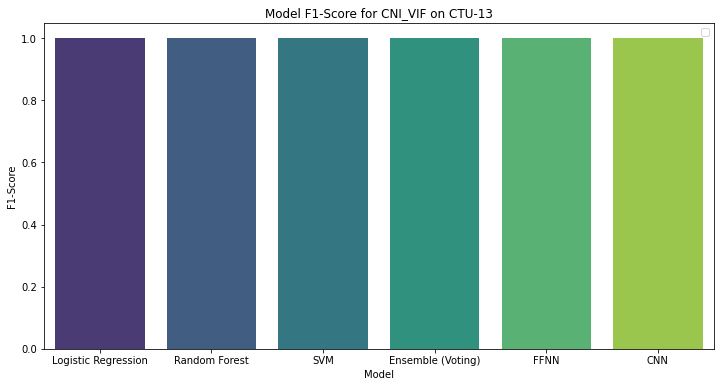

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


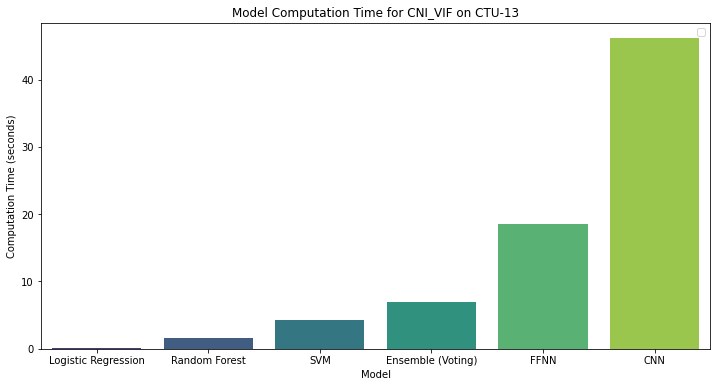

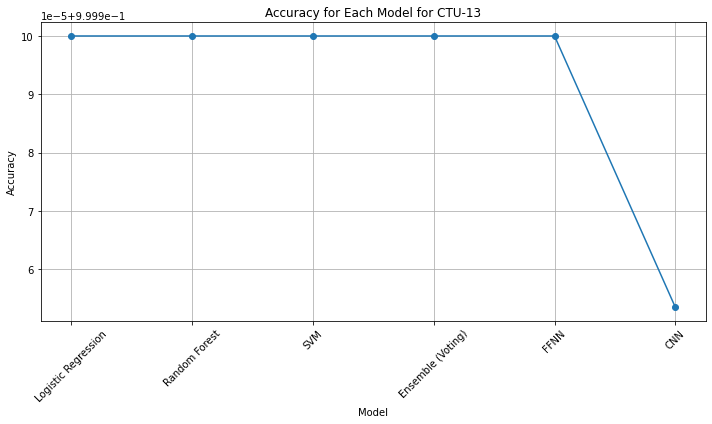

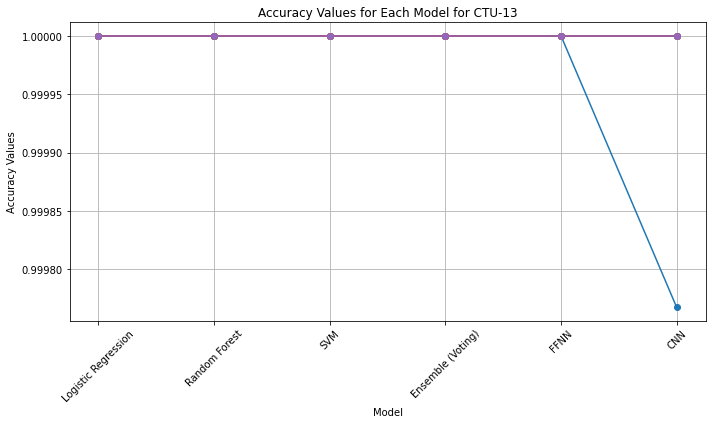

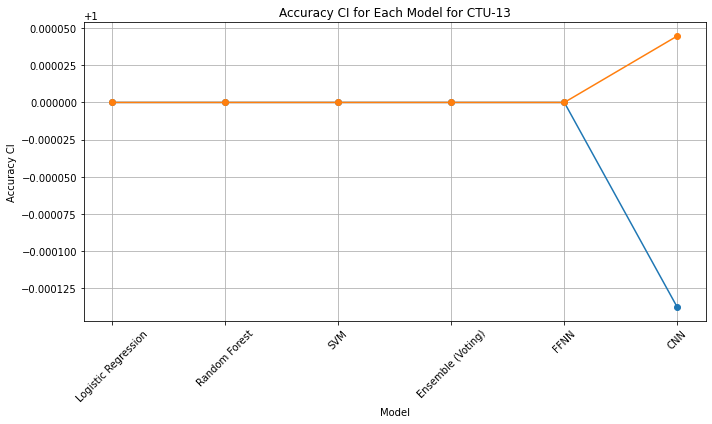

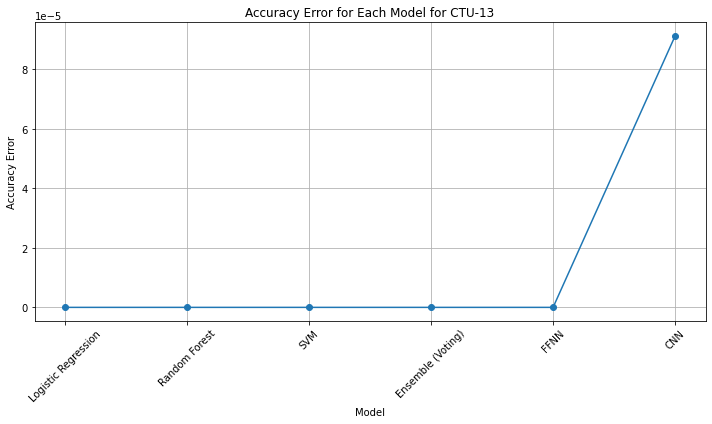

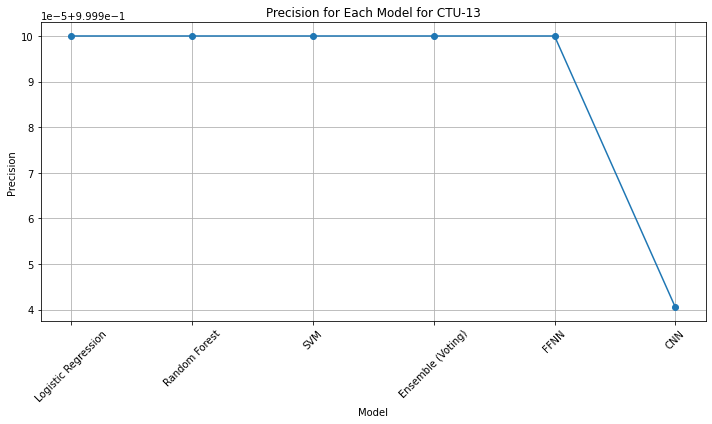

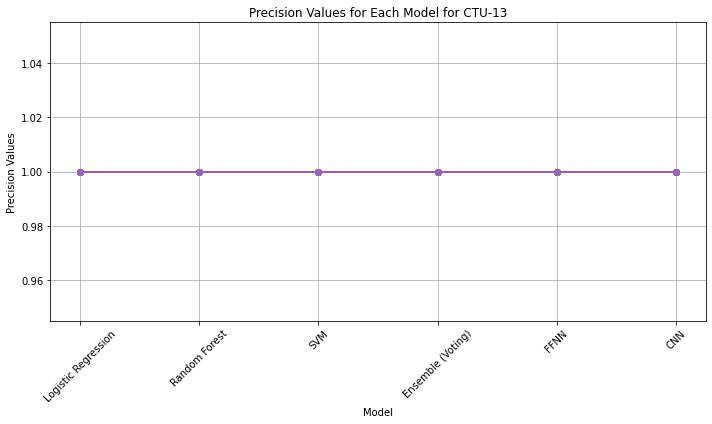

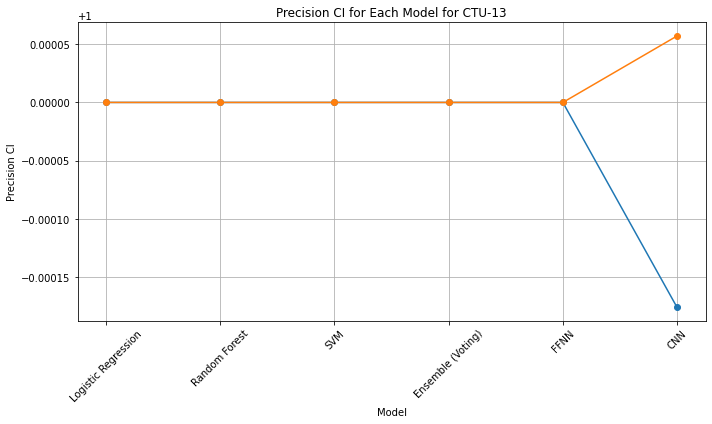

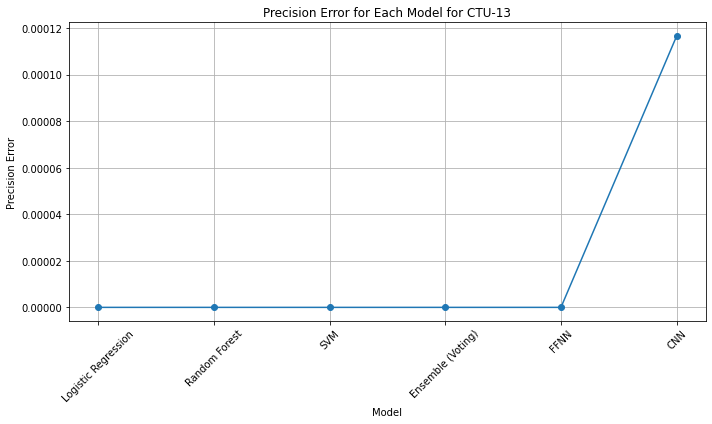

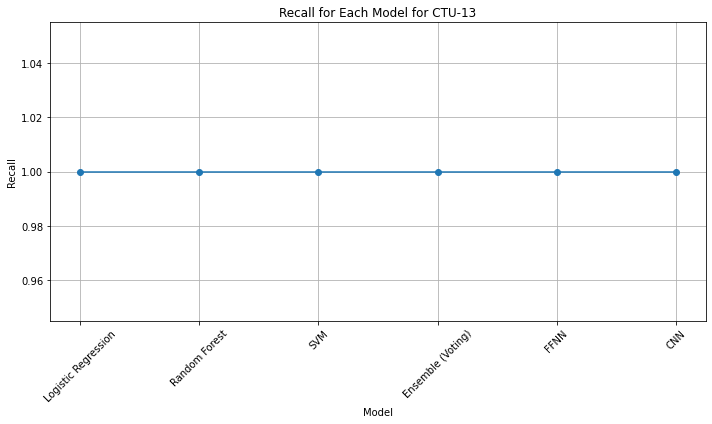

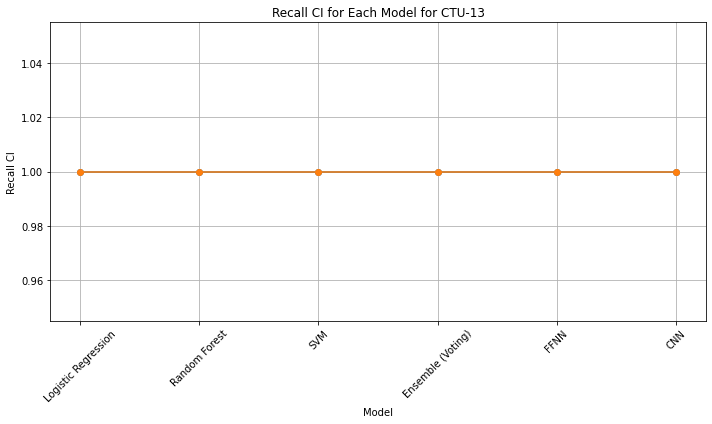

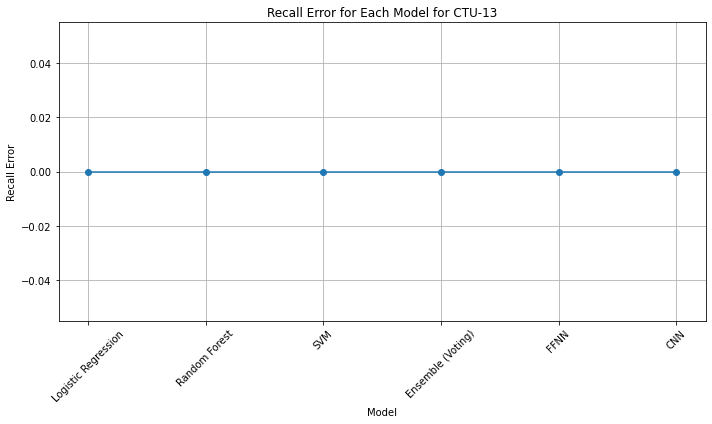

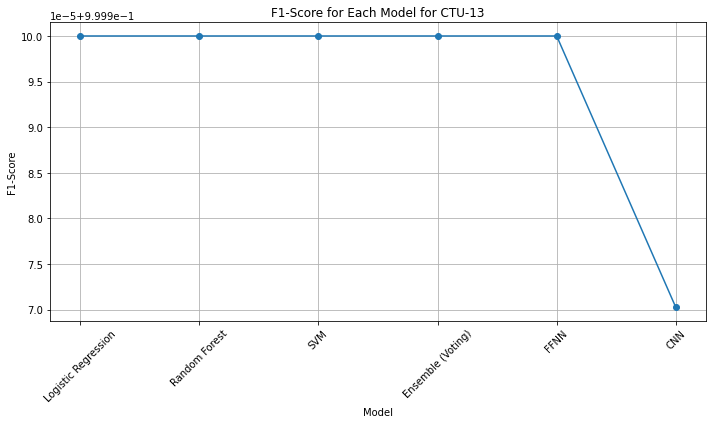

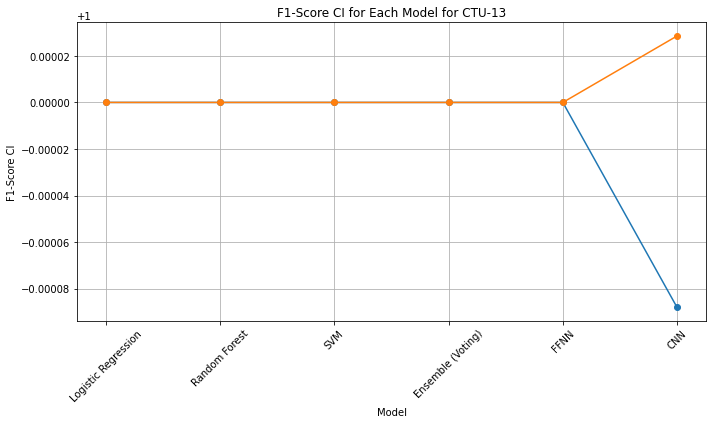

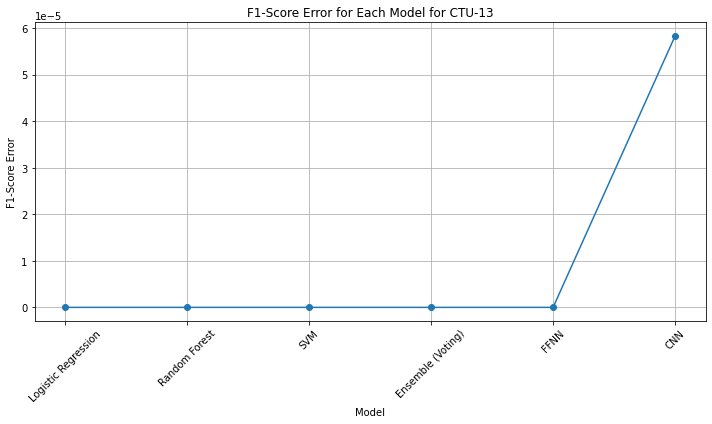

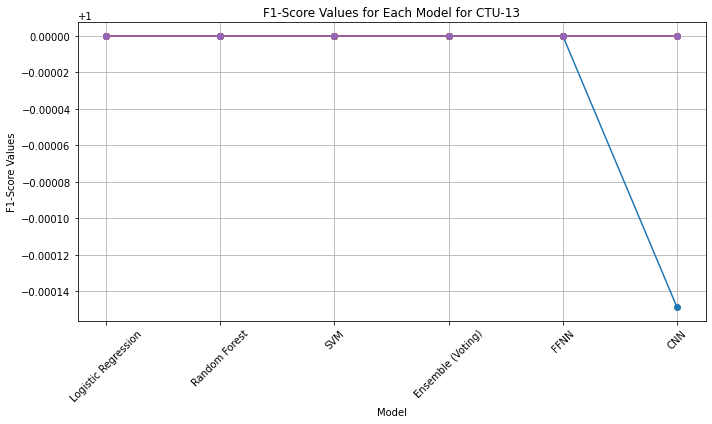

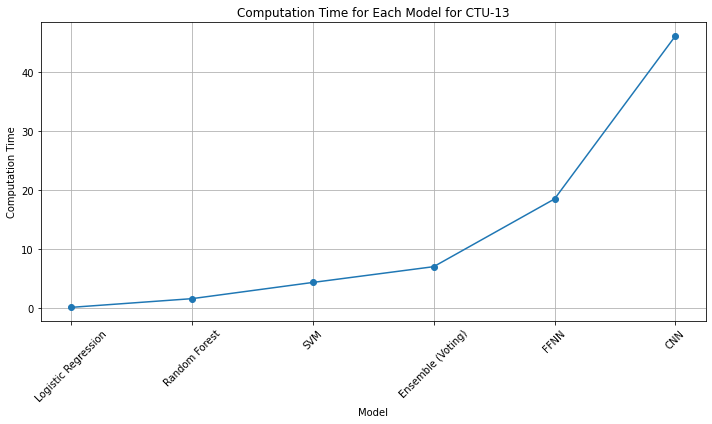

                     Accuracy                           Accuracy Values  \
Logistic Regression       1.0                 [1.0, 1.0, 1.0, 1.0, 1.0]   
Random Forest             1.0                 [1.0, 1.0, 1.0, 1.0, 1.0]   
SVM                       1.0                 [1.0, 1.0, 1.0, 1.0, 1.0]   
Ensemble (Voting)         1.0                 [1.0, 1.0, 1.0, 1.0, 1.0]   
FFNN                      1.0                 [1.0, 1.0, 1.0, 1.0, 1.0]   
CNN                  0.999953  [0.9997673336435552, 1.0, 1.0, 1.0, 1.0]   

                                                  Accuracy CI Accuracy Error  \
Logistic Regression                                (1.0, 1.0)            0.0   
Random Forest                                      (1.0, 1.0)            0.0   
SVM                                                (1.0, 1.0)            0.0   
Ensemble (Voting)                                  (1.0, 1.0)            0.0   
FFNN                                               (1.0, 1.0)            0

C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df["SrcCNI"] = botnet_df[src_col].map(cni_maps).fillna('Unknown')
C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df["DstCNI"] = botnet_df[dst_col].map(cni_maps).fillna('Unknown')


          StartTime   Dur  Proto  SrcAddr  Sport  Dir  DstAddr  Dport  State  \
13960219      11390  5247      1       10     42    0      213     76     11   
13463670      10392  6725      1       11   5483    0      927     65     11   
11477537       8191  7645      1       14     10    0      318     72     39   
14436799      12967  5949      1       13    240    0      873     76     50   
13697551      10831  7914      1       24   7525    2       78      5     26   
...             ...   ...    ...      ...    ...  ...      ...    ...    ...   
14005000      11536  5099      1       11   4669    0      512     45     11   
10966323       7722  9094      1        8     70    0       39     76     48   
6951132        4852  1712      1        5     10    0      641     76     50   
3537473        2316  9116      1       10     43    0       43     79     11   
14601287      13513  2677      1       14   2364    0      535     72     45   

          sTos  ...  Label  ActivityLab

C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[src_col] = botnet_df[src_col].map(reverse_mapping).fillna('Unknown')
C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[dst_col] = botnet_df[dst_col].map(reverse_mapping_dst).fillna('Unknown')


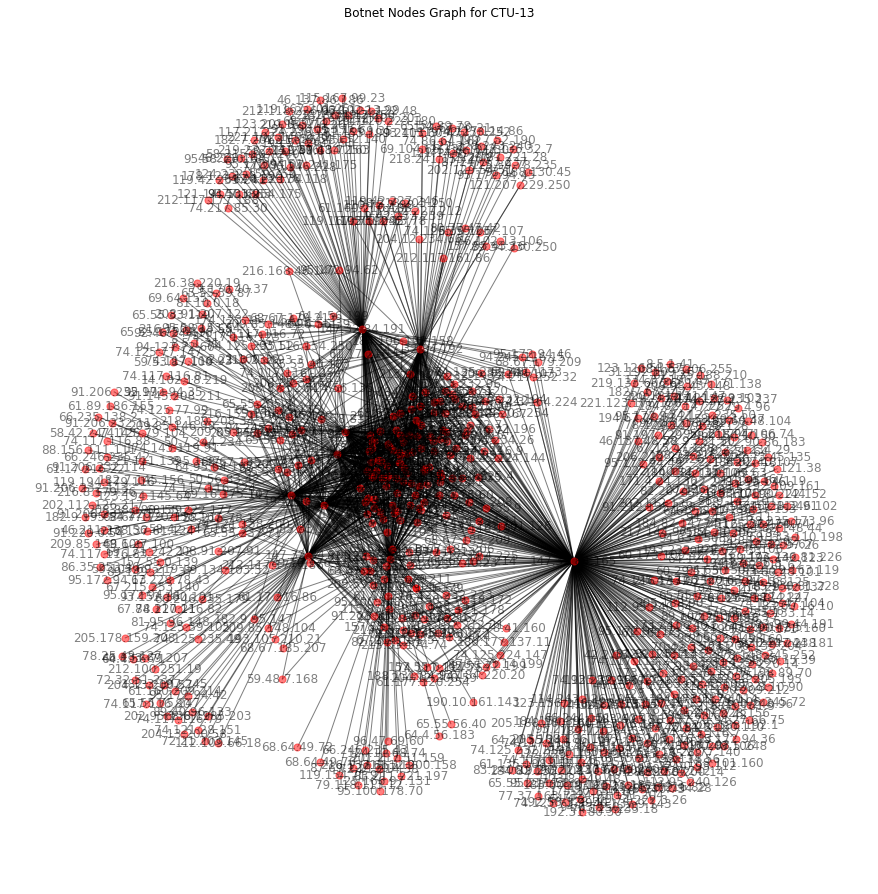

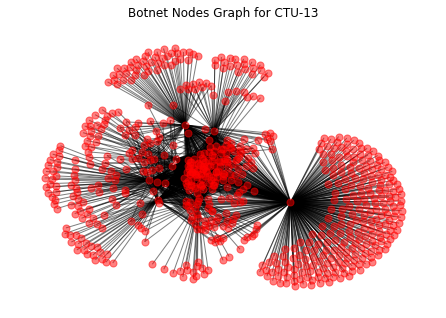

[Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706), Pandas(SrcAddr=4, orig_h_CNI=0.8901511630061706),

In [38]:
process_and_plot(df_ncc,"SrcAddr","DstAddr","ActivityLabel","CTU-13")

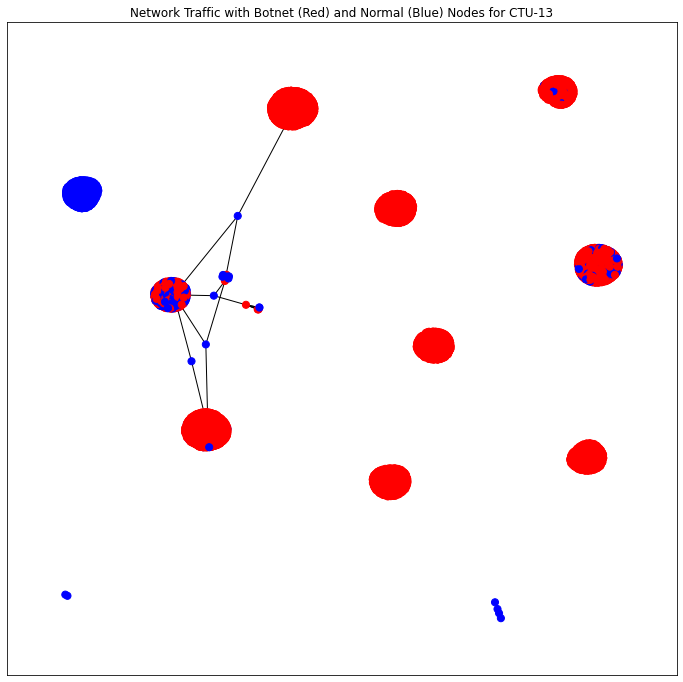

C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1706602215.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vif_results['Traditional_VIF'] = [variance_inflation_factor(X_subset.values, i) for i in range(X_subset.shape[1])]
C:\Users\tejas\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\r

157/157 [==============================] - 1s 4ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


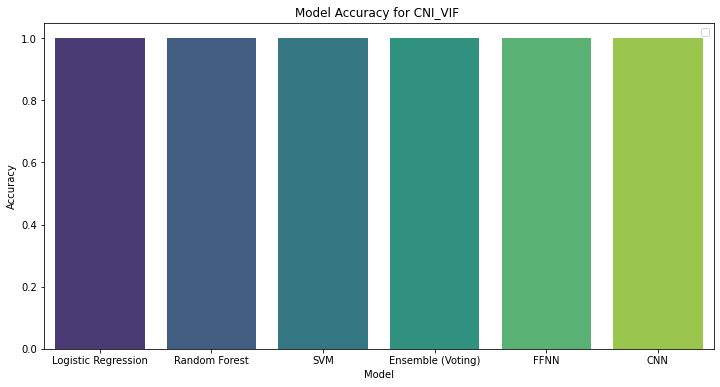

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


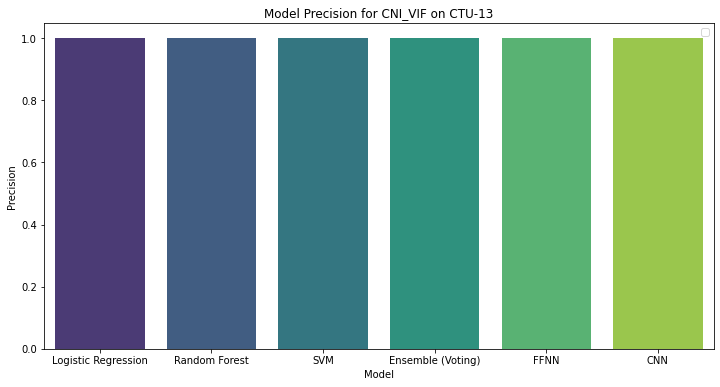

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


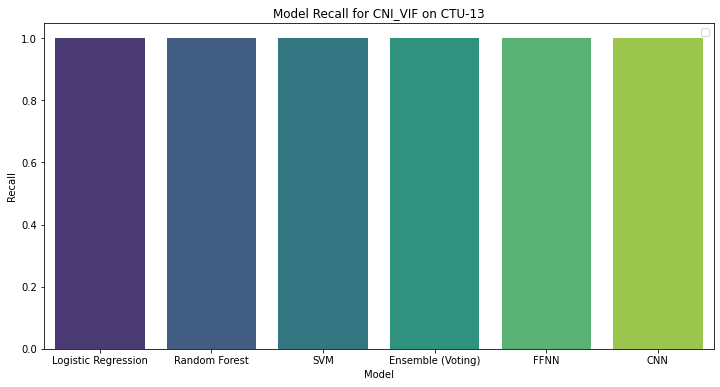

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


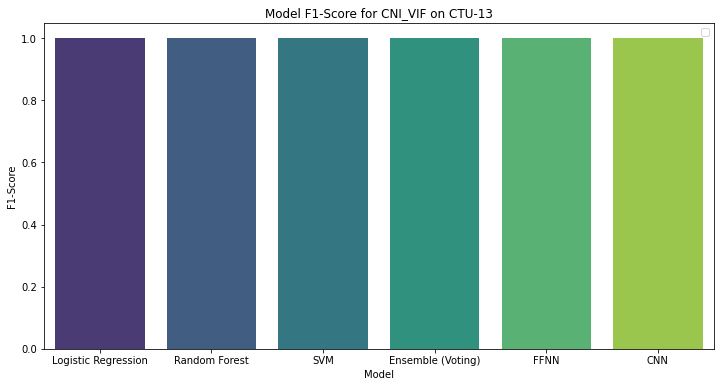

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


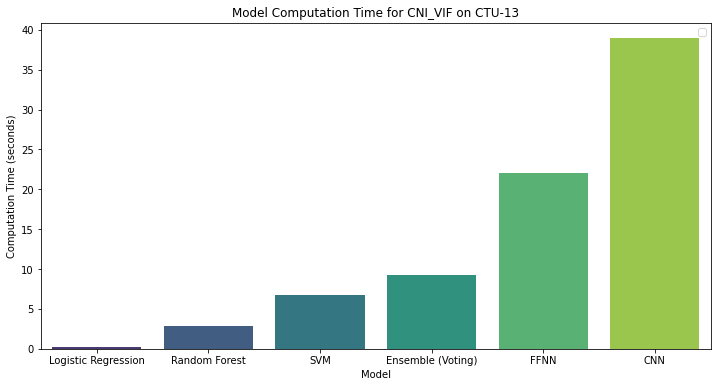

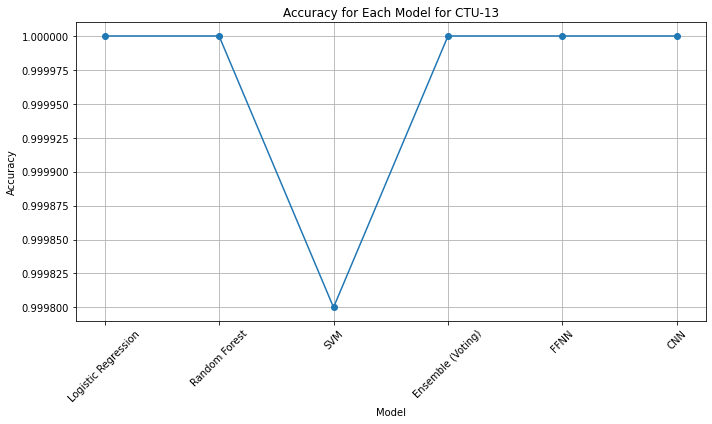

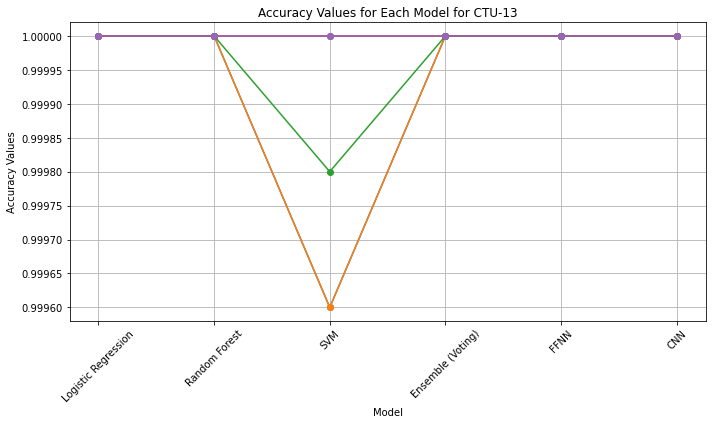

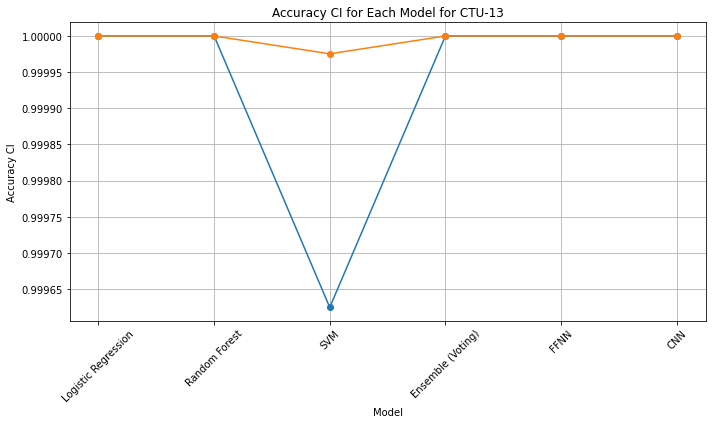

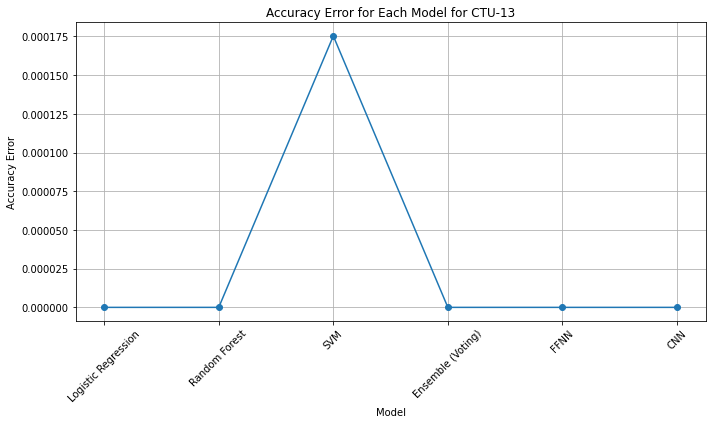

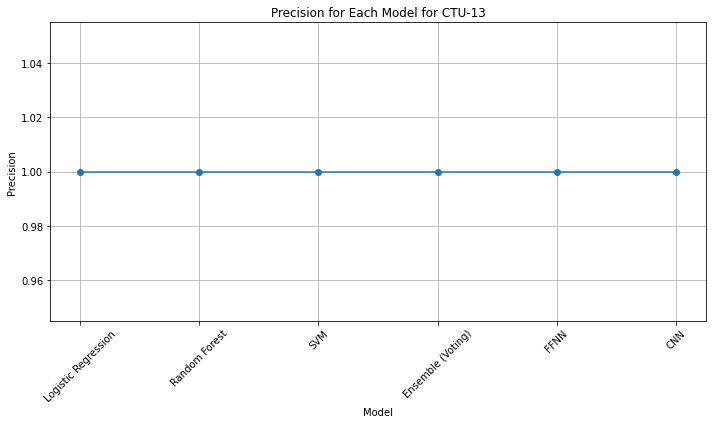

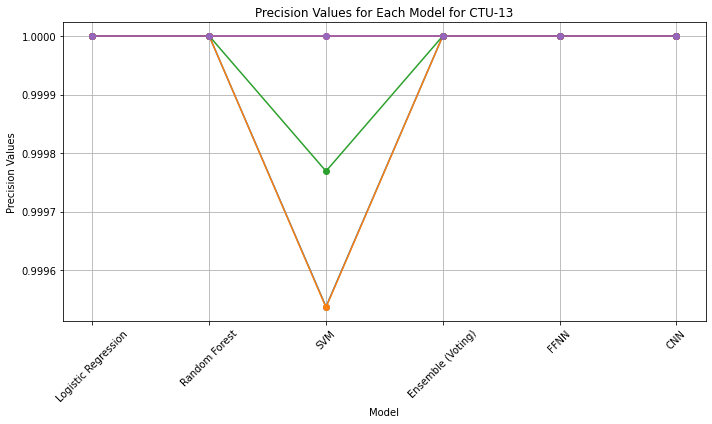

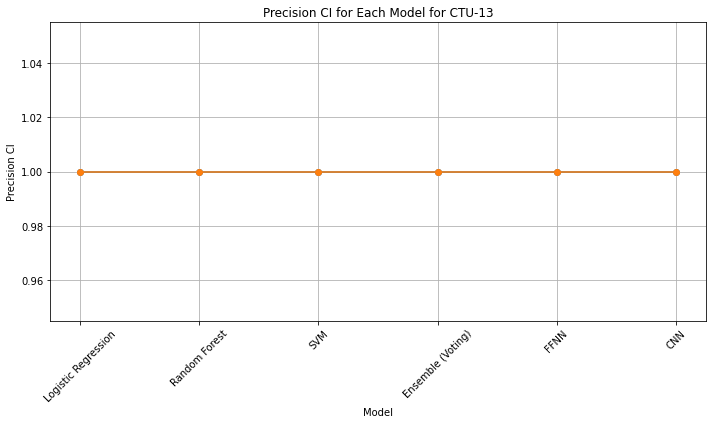

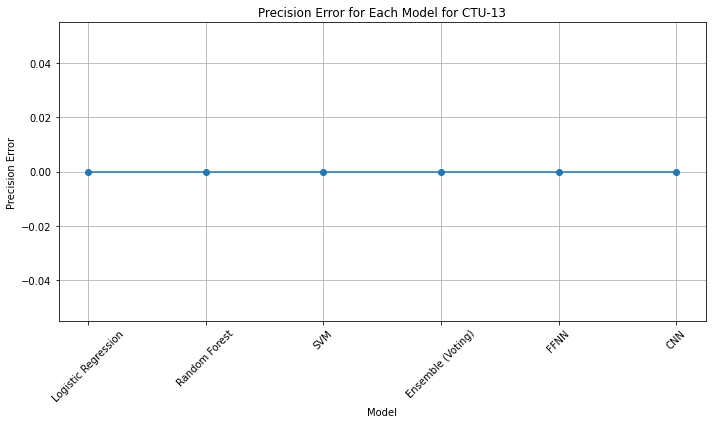

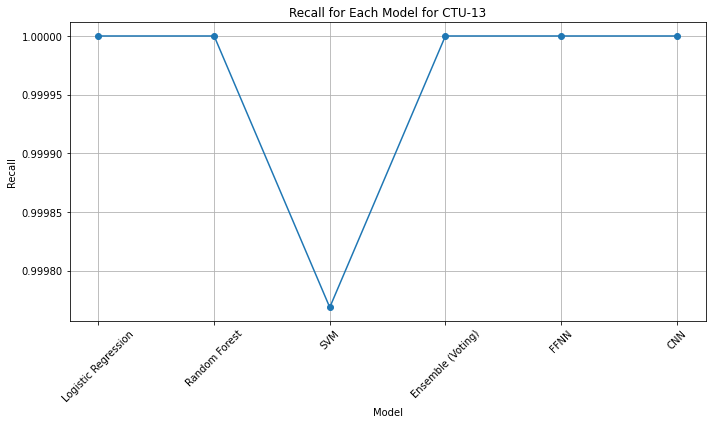

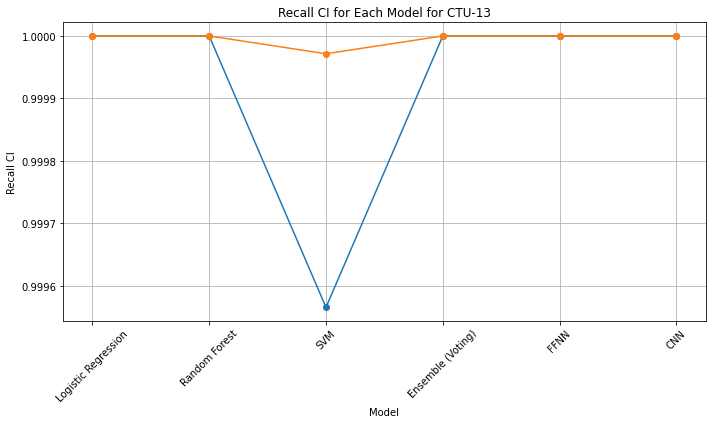

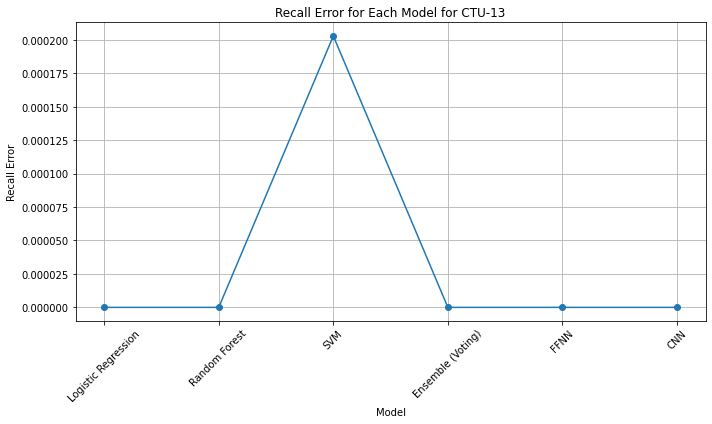

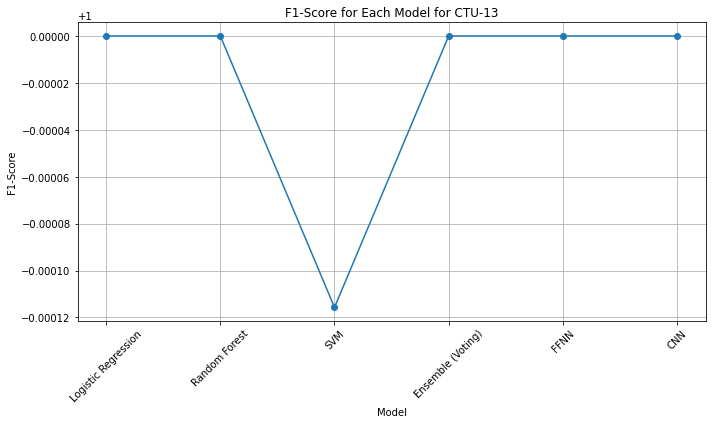

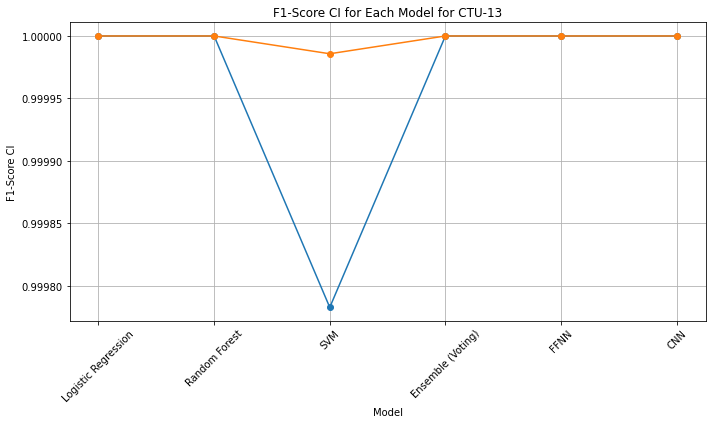

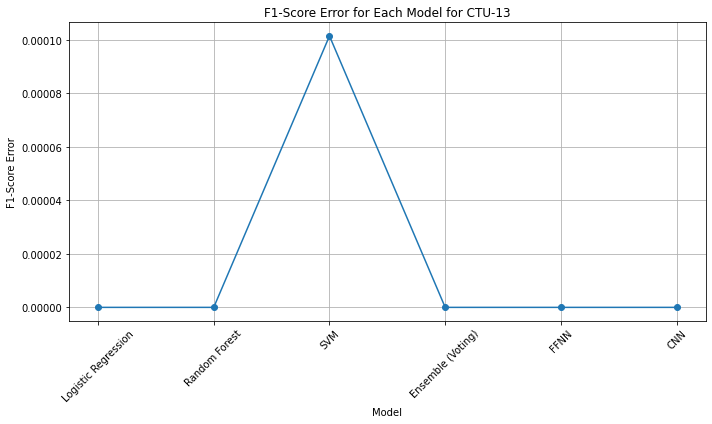

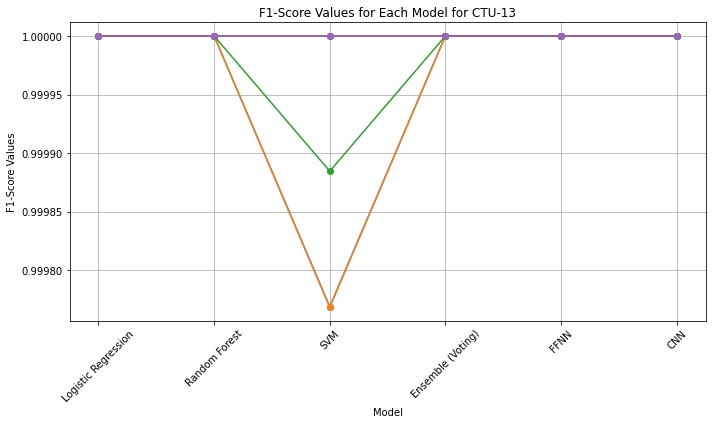

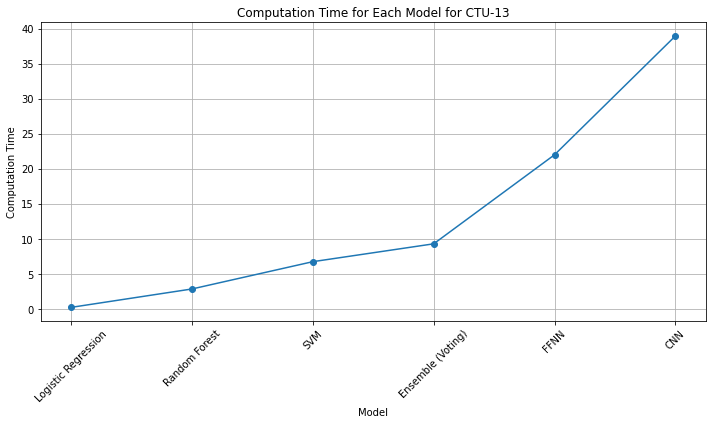

                    Accuracy                     Accuracy Values  \
Logistic Regression      1.0           [1.0, 1.0, 1.0, 1.0, 1.0]   
Random Forest            1.0           [1.0, 1.0, 1.0, 1.0, 1.0]   
SVM                   0.9998  [0.9996, 0.9996, 0.9998, 1.0, 1.0]   
Ensemble (Voting)        1.0           [1.0, 1.0, 1.0, 1.0, 1.0]   
FFNN                     1.0           [1.0, 1.0, 1.0, 1.0, 1.0]   
CNN                      1.0           [1.0, 1.0, 1.0, 1.0, 1.0]   

                                                  Accuracy CI Accuracy Error  \
Logistic Regression                                (1.0, 1.0)            0.0   
Random Forest                                      (1.0, 1.0)            0.0   
SVM                  (0.9996246922705642, 0.9999753077294361)       0.000175   
Ensemble (Voting)                                  (1.0, 1.0)            0.0   
FFNN                                               (1.0, 1.0)            0.0   
CNN                                        

C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df["SrcCNI"] = botnet_df[src_col].map(cni_maps).fillna('Unknown')
C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df["DstCNI"] = botnet_df[dst_col].map(cni_maps).fillna('Unknown')


         Unnamed: 0            ts    uid  id.orig_h  id.orig_p  id.resp_h  \
1243806        9520  1.532101e+09  15001         35     5526.0      20458   
650215        20584  1.547066e+09  14645         26    44469.0      16237   
108044         8045  1.536227e+09   8322         36    18088.0      12625   
128163        28164  1.536227e+09  14816         36    17832.0       5642   
1001926       67637  1.551384e+09   7683         25    30535.0      14222   
...             ...           ...    ...        ...        ...        ...   
198479        98480  1.536227e+09  11889         36    18088.0      21719   
596730        67098  1.545396e+09  21356         30    36097.0       7638   
151712        51713  1.536227e+09   2249         36    18088.0      11848   
1394084       49397  1.532526e+09   4740         36    11332.0      17731   
132302        32303  1.536227e+09  22649         36    17576.0      15550   

         id.resp_p  proto  service  duration  ...  orig_ip_bytes  resp_pkts

C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[src_col] = botnet_df[src_col].map(reverse_mapping).fillna('Unknown')
C:\Users\tejas\AppData\Local\Temp\ipykernel_20356\1303226754.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  botnet_df[dst_col] = botnet_df[dst_col].map(reverse_mapping_dst).fillna('Unknown')


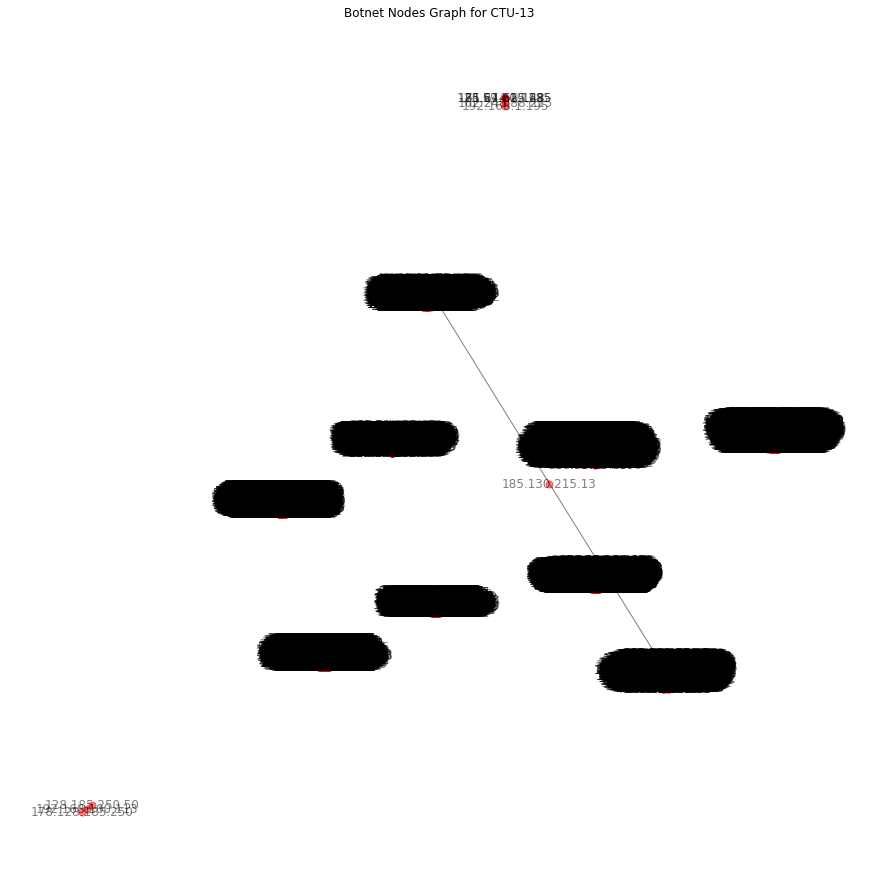

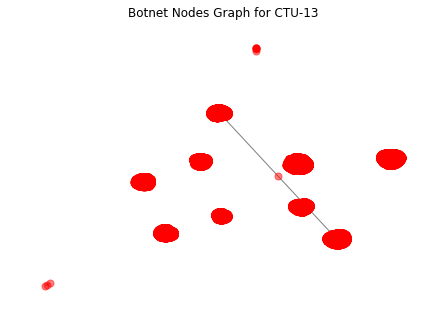

[Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.9726773965789745), Pandas(_0=40, orig_h_CNI=0.972677

In [39]:
process_and_plot(df_iot,"id.orig_h","id.resp_h","ActivityLabel","CTU-13")